# Predicting the Global Spread of COVID-19

On 11 March 2020, the World Health Organization (WHO) officially classified COVID-19 as a pandemic. At the time, the number of confirmed cases were over 130,000 across 114 countries around the world, with the number of deaths caused by the disease over 5,000.

COVID-19 is the acronym of "coronavirus disease 2019" and is the disease caused by a new strain of coronavirus which first appeared in late 2019. According to the WHO, viral diseases like COVID-19 continue to emerge and represent a serious public health risk worldwide. In recent years we have seen the emergence of epidemics such as the severe acute respiratory syndrome coronavirus (SARS-CoV) in 2002 and H1N1 influenza in 2009.

Accurately modelling the spread of these viral diseases is critical for policymakers and health workers to take appropriate actions to contain and mitigate the impact of these disease.

This challenge asks data scientists on Zindi to accurately predict the spread of COVID-19 around the world over the next few months. Solutions will be evaluated against future data.

In [162]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
import xgboost as xgb
import lightgbm as lgbm
from sklearn.ensemble import RandomForestRegressor

# Input data files are available in the "../input/" directory.

import os
for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

./torch_regression.py
./covid-19-rnn.ipynb
./covid-19-forecasting-with-an-rnn-2.ipynb
./best_model.h5
./covid_rf_model.ipynb
./RNN.ipynb
./submission/sub.csv
./proc_data/train.csv
./proc_data/test.csv
./proc_data/SampleSubmission.csv
./raw_data/Population density by countries.csv
./raw_data/train.csv
./raw_data/region_metadata.csv
./raw_data/SampleSubmission.csv
./raw_data/population_by_country_2020.csv
./.ipynb_checkpoints/RNN-checkpoint.ipynb
./.ipynb_checkpoints/covid-19-rnn-checkpoint.ipynb
./.ipynb_checkpoints/covid_rf_model-checkpoint.ipynb
./.ipynb_checkpoints/covid-19-forecasting-with-an-rnn-2-checkpoint.ipynb


In [187]:
#  Loading data
train_df = pd.read_csv('./raw_data/train.csv')
test = pd.read_csv('./proc_data/test.csv')
region_metadata = pd.read_csv('./raw_data/region_metadata.csv')
sub = pd.read_csv('./raw_data/SampleSubmission.csv')

train_df.dtypes

Territory X Date    object
target               int64
cases                int64
Territory           object
Date                object
dtype: object

In [188]:
## TEST gen. snippet
#remove leading zero on the month (for submission validity)
#dates = pd.date_range(start='2020-03-06', end='2020-06-07', freq='1d')
#ids = []
#for c in sorted(train_df['Territory'].unique()):
#  for d in dates:
#    ids.append(c + ' X ' + d.strftime('%m/%-d/%y').lstrip('0'))
#sub = pd.DataFrame({'Territory X Date':ids, 'target':0})

# expanding the first column into two
#sub[['Territory','Date']] = sub['Territory X Date'].str.split("X",expand=True)

# convert date column to datetime.
#sub['Date'] = pd.to_datetime(sub.Date)
#sub.head()

In [189]:
#%mkdir ./proc_data
#sub.to_csv('./proc_data/test.csv', index=False)
test.head()

,Territory X Date,target,Territory,Date
0,Afghanistan X 3/6/20,0,Afghanistan,2020-03-06
1,Afghanistan X 3/7/20,0,Afghanistan,2020-03-07
2,Afghanistan X 3/8/20,0,Afghanistan,2020-03-08
3,Afghanistan X 3/9/20,0,Afghanistan,2020-03-09
4,Afghanistan X 3/10/20,0,Afghanistan,2020-03-10


In [190]:
# Cast Date to datetime
train_df['Date'] = pd.to_datetime(train_df['Date'])
test['Date'] = pd.to_datetime(test['Date'])

In [191]:
#region_metadata = region_metadata.drop('Province_State', axis=1)
region_metadata = region_metadata.rename(index=str, columns={'Country_Region': 'Territory'})

# merging external metadata
#train_df = train_df.merge(region_metadata, on = ["Territory"], how='left')
#test = test.merge(region_metadata, on = ["Territory"], how='left')

# label encoding continent
#train_df.continent = LabelEncoder().fit_transform(train_df.continent)
#test.continent = LabelEncoder().fit_transform(test.continent)

train_df.sort_values(["Territory", "Date"], inplace = True)

In [192]:
# fixing data issues with cummax
#comb_df.cases = comb_df.groupby("Territory")["cases"].cummax()
#comb_df.target = comb_df.groupby("Territory")["target"].cummax()
test.head()

,Territory X Date,target,Territory,Date
0,Afghanistan X 3/6/20,0,Afghanistan,2020-03-06
1,Afghanistan X 3/7/20,0,Afghanistan,2020-03-07
2,Afghanistan X 3/8/20,0,Afghanistan,2020-03-08
3,Afghanistan X 3/9/20,0,Afghanistan,2020-03-09
4,Afghanistan X 3/10/20,0,Afghanistan,2020-03-10


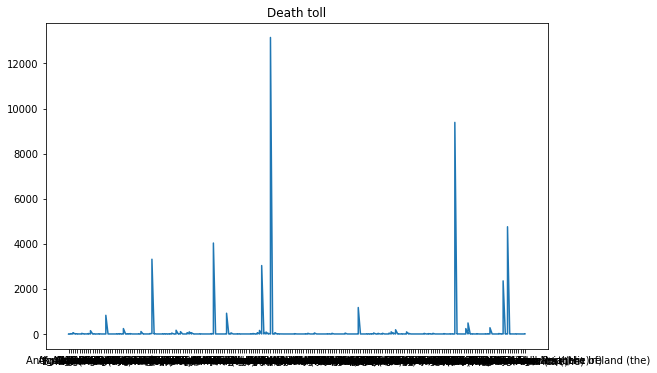

In [193]:
plt.figure(figsize=(9,6))
plt.plot(train_df['Territory'], train_df.target)
plt.title('Death toll')
plt.show()

## Creating new features

In [194]:
def create_time_features(df):
    """
    Creates time series features from datetime index
    """
    #df['date'] = df.index
    df['hour'] = df['Date'].dt.hour
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['quarter'] = df['Date'].dt.quarter
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['dayofyear'] = df['Date'].dt.dayofyear
    df['dayofmonth'] = df['Date'].dt.day
    df['day'] = df['Date'].dt.day
    
    X = df[['dayofweek','month', 'day', 'hour', 'quarter',
            'year', 'dayofyear', 'dayofmonth']]
    return X

In [195]:
create_time_features(train_df)
create_time_features(test)

,dayofweek,month,day,hour,quarter,year,dayofyear,dayofmonth
0,4,3,6,0,1,2020,66,6
1,5,3,7,0,1,2020,67,7
2,6,3,8,0,1,2020,68,8
3,0,3,9,0,1,2020,69,9
4,1,3,10,0,1,2020,70,10
5,2,3,11,0,1,2020,71,11
6,3,3,12,0,1,2020,72,12
7,4,3,13,0,1,2020,73,13
8,5,3,14,0,1,2020,74,14
9,6,3,15,0,1,2020,75,15


In [196]:
# cheking for null values
train_df = train_df.dropna()
train_df.isnull().sum()

Territory X Date    0
target              0
cases               0
Territory           0
Date                0
hour                0
dayofweek           0
quarter             0
month               0
year                0
dayofyear           0
dayofmonth          0
day                 0
dtype: int64

In [197]:
test.head()

,Territory X Date,target,Territory,Date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,day
0,Afghanistan X 3/6/20,0,Afghanistan,2020-03-06,0,4,1,3,2020,66,6,6
1,Afghanistan X 3/7/20,0,Afghanistan,2020-03-07,0,5,1,3,2020,67,7,7
2,Afghanistan X 3/8/20,0,Afghanistan,2020-03-08,0,6,1,3,2020,68,8,8
3,Afghanistan X 3/9/20,0,Afghanistan,2020-03-09,0,0,1,3,2020,69,9,9
4,Afghanistan X 3/10/20,0,Afghanistan,2020-03-10,0,1,1,3,2020,70,10,10


In [198]:
# One-hot encoding the Territory feature
train_df = pd.concat([train_df, pd.get_dummies(train_df['Territory'], prefix='tr')], axis=1)

test = pd.concat([test, pd.get_dummies(test['Territory'], prefix='tr')], axis=1)
test.drop(['Territory'],axis=1, inplace=True)

train_df.head()

,Territory X Date,target,cases,Territory,Date,hour,dayofweek,quarter,month,year,...,tr_United Republic of Tanzania (the),tr_United States of America (the),tr_Uruguay,tr_Uzbekistan,tr_Vanuatu,tr_Venezuela (Bolivarian Republic of),tr_Viet Nam,tr_Yemen,tr_Zambia,tr_Zimbabwe
0,Afghanistan X 1/22/20,0,0,Afghanistan,2020-01-22,0,2,1,1,2020,...,0,0,0,0,0,0,0,0,0,0
1,Afghanistan X 1/23/20,0,0,Afghanistan,2020-01-23,0,3,1,1,2020,...,0,0,0,0,0,0,0,0,0,0
2,Afghanistan X 1/24/20,0,0,Afghanistan,2020-01-24,0,4,1,1,2020,...,0,0,0,0,0,0,0,0,0,0
3,Afghanistan X 1/25/20,0,0,Afghanistan,2020-01-25,0,5,1,1,2020,...,0,0,0,0,0,0,0,0,0,0
4,Afghanistan X 1/26/20,0,0,Afghanistan,2020-01-26,0,6,1,1,2020,...,0,0,0,0,0,0,0,0,0,0


In [199]:
# cases
y1 = train_df[['cases']]
# deaths
y2 = train_df[['target']]
# Matching training features
train_df.drop(['Territory X Date', 'Territory', 'Date', 'target', 'cases'], axis=1, inplace=True)

In [200]:
Id = test[['Territory X Date']]
test.drop(['Territory X Date', 'Date', 'target'], axis=1, inplace=True)

#train_df['Territory'] = LabelEncoder().fit_transform(train_df.Territory)
#test['Territory'] = LabelEncoder().fit_transform(test.Territory)
test.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,day,tr_Afghanistan,tr_Albania,...,tr_United Republic of Tanzania (the),tr_United States of America (the),tr_Uruguay,tr_Uzbekistan,tr_Vanuatu,tr_Venezuela (Bolivarian Republic of),tr_Viet Nam,tr_Yemen,tr_Zambia,tr_Zimbabwe
0,0,4,1,3,2020,66,6,6,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,5,1,3,2020,67,7,7,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,6,1,3,2020,68,8,8,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,3,2020,69,9,9,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,1,3,2020,70,10,10,1,0,...,0,0,0,0,0,0,0,0,0,0


## Building the model:

Since the number of cases seems have a strong relationship with the number of deaths (our target), we build a model to predict the number of cases for the test set after which we use this result to predict the final number of fatalities in the test set.

In [201]:

train_df.shape, test.shape

((14839, 217), (19646, 217))

In [202]:
features = ['month', 'dayofmonth', 'dayofweek', 'dayofyear']
    
for f in features:
    for i in range(1, 41):
        train_df[f + '_lag' + str(i+1)] = train_df[f].shift(i)
        test[f + '_lag' + str(i+1)] = test[f].shift(i)

In [203]:
train_df.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [204]:
# Predicting fatalities/deaths

model = RandomForestRegressor(bootstrap=True,max_depth=5, max_features='auto', 
                      n_estimators=250, random_state=42, n_jobs=-1, verbose=0)
model.fit(train_df, y2)
pred2 = model.predict(test)
#pred2 = pd.DataFrame(pred2)
#pred2.columns = ["prediction"]

/home/quanta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


In [205]:
max((pred2))

11993.023466666671

In [206]:
submission = Id
submission['target'] = np.round((pred2))
submission.head()

/home/quanta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Territory X Date,target
0,Afghanistan X 3/6/20,10.0
1,Afghanistan X 3/7/20,10.0
2,Afghanistan X 3/8/20,10.0
3,Afghanistan X 3/9/20,10.0
4,Afghanistan X 3/10/20,10.0


In [207]:
#%mkdir submission
submission.to_csv("./submission/sub.csv",index=False)